# understanding AC pair reactivity trends

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from tabulate import tabulate

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)

## extra functions

### plotting

In [3]:
def plot_side_diff_violinplot(df_pos, color="tab:red"):
    df_pos["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
    ]
    df_pos["side_diff"] = df_pos["side_diff"].astype(str)
    df_pos.sort_values("side_diff", inplace=True, ascending=True)

    # Calculate percentage over threshold for each side_diff
    percentages = (
        df_pos.groupby("side_diff")
        .apply(lambda x: (x["ln_r_data"] < -5.45).mean() * 100)
        .round(2)
    )

    fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
    ax = sns.violinplot(
        data=df_pos,
        x="ln_r_data",
        y="side_diff",
        density_norm="width",
        color=color,
        linewidth=0.5,
        ax=ax,
    )
    ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
    ax.set_xlim(-10, -1)
    ax.set_xticks([-10, -8, -6, -4, -2])
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
    # Add percentage labels
    for i, (side_diff, percentage) in enumerate(percentages.items()):
        ax.text(-8, i + 0.03, f"{percentage:.2f}%", va="center", ha="right")
    format_small_plot(ax)

    return fig, ax

### summary tables

In [4]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

### misc

In [5]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

## load data

In [6]:
DATA_PATH = "../data"

In [7]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
df_pdb_ac = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-C' and no_of_interactions == 1"
).copy()

In [8]:
df_pdb.iloc[0]

m_sequence                                                       AAAC_GCU
r_nuc                                                                   A
pdb_r_pos                                                               3
r_type                                                                 WC
pdb_r_bp_type                                                         cWW
pdb_r_pair                                                            A-U
no_of_conformations                                                     1
no_of_interactions                                                      1
pdb_name                                   TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_path                data/pdbs/AAAC_GCU/TWOWAY.6NY2.1-2.GCU-AAAC.0.pdb
pdb_res                                                               3.2
both_purine                                                           1.0
both_pyrimidine                                                       0.0
constructs                            

# All residues

## C reactivity trends

In [9]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
print(len(df_ca["m_sequence"].unique()))

203


### Stacking trends

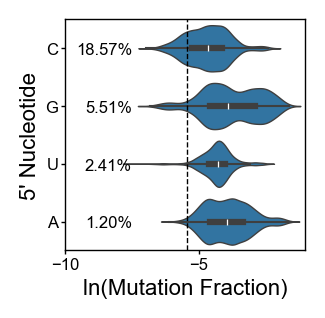

In [11]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
ax = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "p5_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("5' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

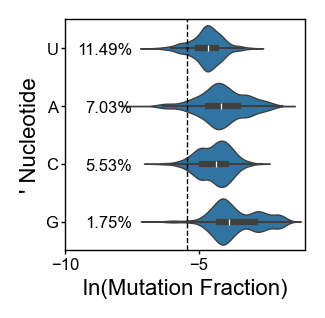

In [70]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
ax = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "p3_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

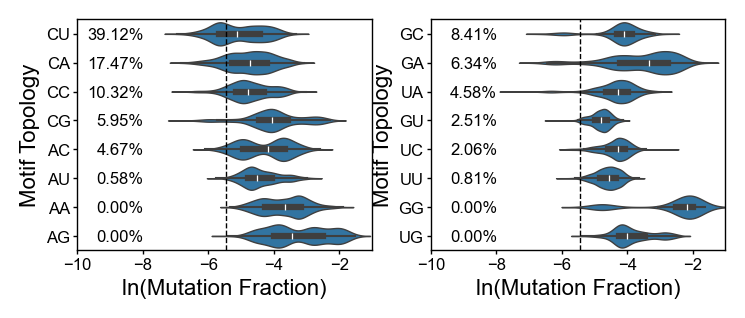

In [53]:
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
ax = plot_violins_w_percent_groups(
    df_ca,
    "ln_r_data",
    "r_stack",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)

In [54]:
create_summary_table(df_ca, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CU        | 39.12%          |    1025 |
| CA        | 17.47%          |    1935 |
| CC        | 10.32%          |     959 |
| GC        | 8.41%           |     440 |
| GA        | 6.34%           |    1641 |
| CG        | 5.95%           |     874 |
| AC        | 4.67%           |    1136 |
| UA        | 4.58%           |    2272 |
| GU        | 2.51%           |     438 |
| UC        | 2.06%           |    1410 |
| UU        | 0.81%           |    1229 |
| AU        | 0.58%           |    1033 |
| UG        | 0.00%           |    1030 |
| GG        | 0.00%           |     241 |
| AA        | 0.00%           |    1916 |
| AG        | 0.00%           |     831 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:464: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


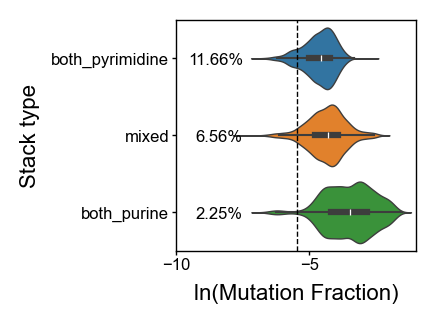

In [55]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

## A reactivity trends

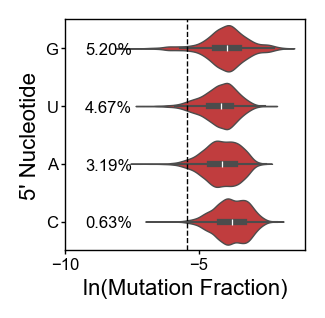

In [61]:
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
ax = plot_violins_w_percent(
    df_ac,
    "ln_r_data",
    "p5_res",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("5' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

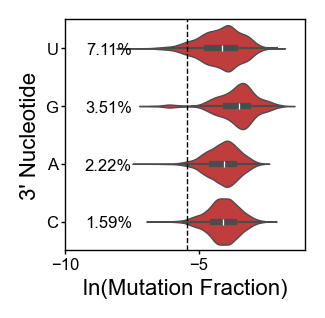

In [60]:
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
ax = plot_violins_w_percent(
    df_ac,
    "ln_r_data",
    "p3_res",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("3' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

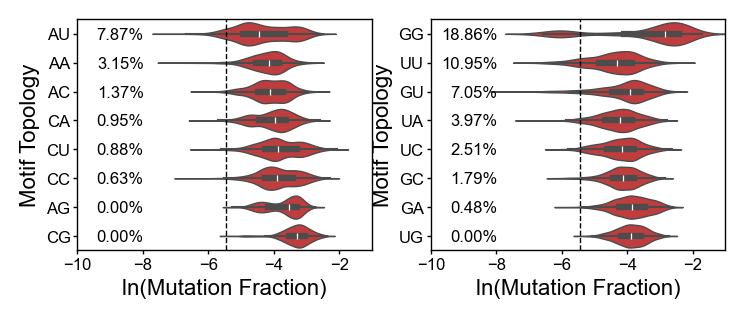

In [63]:
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
ax = plot_violins_w_percent_groups(
    df_ac,
    "ln_r_data",
    "r_stack",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)

In [ ]:
create_summary_table(df_ac, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| GG        | 18.86%          |     525 |
| UU        | 10.95%          |    1425 |
| AU        | 7.87%           |    1232 |
| GU        | 7.05%           |    1064 |
| UA        | 3.97%           |    1033 |
| AA        | 3.15%           |     793 |
| UC        | 2.51%           |    2035 |
| GC        | 1.79%           |    1512 |
| AC        | 1.37%           |    2051 |
| CA        | 0.95%           |     843 |
| CU        | 0.88%           |    1018 |
| CC        | 0.63%           |    1741 |
| GA        | 0.48%           |     841 |
| AG        | 0.00%           |     630 |
| CG        | 0.00%           |     849 |
| UG        | 0.00%           |     818 |


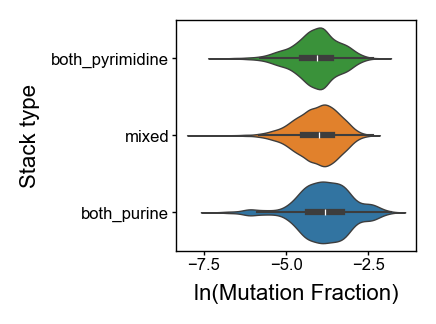

In [ ]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca = df.query("likely_pair == 'AC'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
sns.violinplot(
    data=df_ca,
    y="stack_type",
    x="ln_r_data",
    hue="stack_type",
    order=["both_pyrimidine", "mixed", "both_purine"],
    ax=ax,
    linewidth=0.5,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

# single mismatches

In [ ]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
df_ac_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '1x1'"
).copy()

Text(0.5, 0, 'ln(Mutation Fraction)')

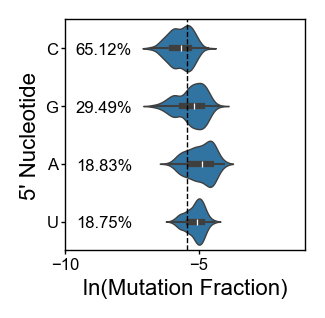

In [65]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
ax = plot_violins_w_percent(
    df_ca_1x1,
    "ln_r_data",
    "p5_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
format_small_plot(ax)
ax.set_ylabel("5' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)

Text(0.5, 0, 'ln(Mutation Fraction)')

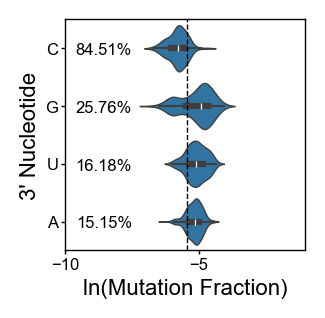

In [66]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
ax = plot_violins_w_percent(
    df_ca_1x1,
    "ln_r_data",
    "p3_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
format_small_plot(ax)
ax.set_ylabel("3' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)

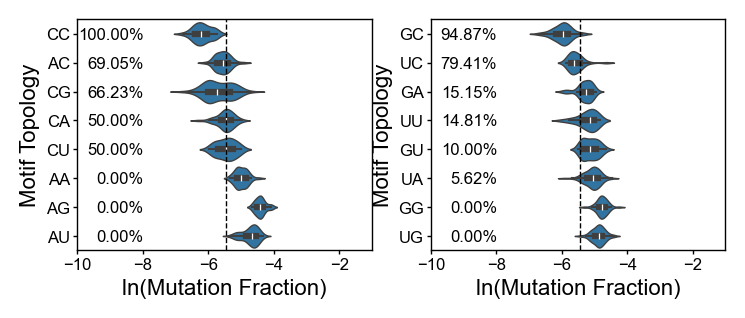

In [69]:
df_ca_1x1 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '1x1'"
).copy()
ax = plot_violins_w_percent_groups(
    df_ca_1x1,
    "ln_r_data",
    "r_stack",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)

In [ ]:
create_summary_table(df_ca_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| CC        | 100.00%         |      27 |
| GC        | 94.87%          |      39 |
| UC        | 79.41%          |      34 |
| AC        | 69.05%          |      42 |
| CG        | 66.23%          |      77 |
| CU        | 50.00%          |      28 |
| CA        | 50.00%          |      40 |
| GA        | 15.15%          |      33 |
| UU        | 14.81%          |      27 |
| GU        | 10.00%          |      40 |
| UA        | 5.62%           |      89 |
| AU        | 0.00%           |      41 |
| AA        | 0.00%           |      36 |
| AG        | 0.00%           |      35 |
| UG        | 0.00%           |      42 |
| GG        | 0.00%           |      44 |


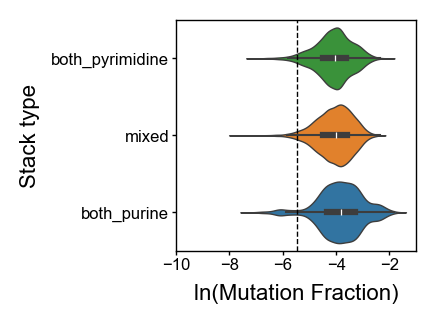

In [ ]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca_1x1["stack_type"] = df_ca_1x1.apply(assign_stack_type, axis=1)
sns.violinplot(
    data=df_ca,
    y="stack_type",
    x="ln_r_data",
    hue="stack_type",
    order=["both_pyrimidine", "mixed", "both_purine"],
    ax=ax,
    linewidth=0.5,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

In [ ]:
df_ca_2x2 = df.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA' and m_token == '2x2'"
).copy()
df_ac_2x2 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC' and m_token == '2x2'"
).copy()

p5_res
A     0.66
C    15.68
G     0.35
U     0.19
dtype: float64
Index(['C', 'A', 'G', 'U'], dtype='object', name='p5_res')


(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="5' Nucleotide">)

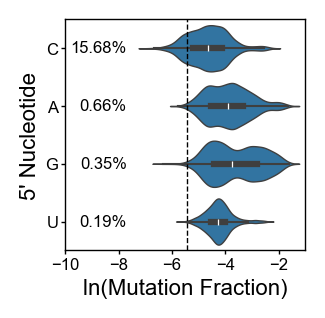

In [ ]:
plot_violins_w_percent_groups(df_ca_2x2, "p5_res", color="tab:blue")

p3_res
A     3.20
C     2.98
G     0.04
U    11.31
dtype: float64
Index(['U', 'A', 'C', 'G'], dtype='object', name='p3_res')


(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="3' Nucleotide">)

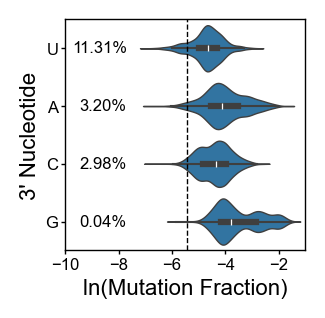

In [ ]:
plot_violins_w_percent_groups(df_ca_2x2, "p3_res", color="tab:blue")

In [ ]:
df_ca_2x2.iloc[0]

both_purine                    False
both_pyrimidine                False
constructs              construct198
has_pdbs                       False
likely_pair                       CA
m_flank_bp_5p                     AU
m_flank_bp_3p                     AU
m_orientation            non-flipped
m_pos                              3
m_second_flank_bp_5p              UA
m_second_flank_bp_3p              CG
m_sequence                 AAAA&UACU
m_structure                (..(&)..)
m_token                          2x2
n_pdbs                             0
pair_type                        NaN
p5_res                             A
p5_type                       PURINE
p3_res                             U
p3_type                   PYRIMIDINE
r_data                       0.03275
r_nuc                              C
r_loc_pos                          7
r_pos                             86
r_type                        NON-WC
r_stack                           AU
pdb_path                          []
p

r_stack
AA     0.00
AC     2.42
AG     0.00
AU     0.60
CA    12.05
CC     9.93
CG     0.13
CU    38.82
GA     0.08
GC     0.00
GG     0.00
GU     1.76
UA     0.10
UC     0.17
UG     0.00
UU     0.50
dtype: float64
Index(['CU', 'CA', 'CC', 'AC', 'GU', 'AU', 'UU', 'UC', 'CG', 'UA', 'GA', 'AA',
       'AG', 'GC', 'GG', 'UG'],
      dtype='object', name='r_stack')


(<Figure size 400x600 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Stack'>)

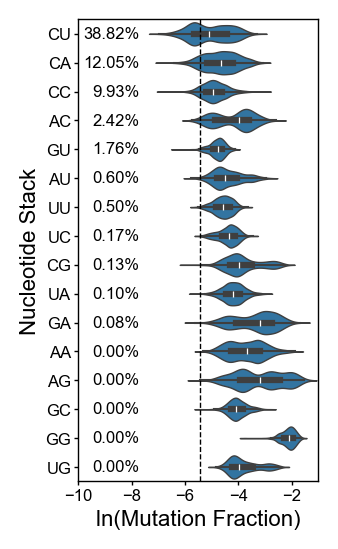

In [ ]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
plot_violins_w_percent_groups(df_ca_2x2, "r_stack", color="tab:blue", ax=ax)

p5_res
A    2.22
C    0.31
G    2.03
U    4.64
dtype: float64
Index(['U', 'A', 'G', 'C'], dtype='object', name='p5_res')


(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="5' Nucleotide">)

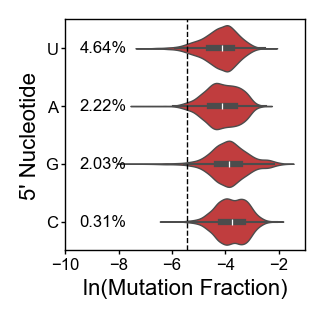

In [ ]:
plot_violins_w_percent_groups(df_ac_2x2, "p5_res", color="tab:red")

p3_res
A    1.56
C    0.87
G    0.00
U    6.72
dtype: float64
Index(['U', 'A', 'C', 'G'], dtype='object', name='p3_res')


(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel="3' Nucleotide">)

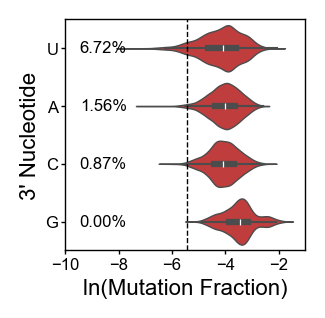

In [ ]:
plot_violins_w_percent_groups(df_ac_2x2, "p3_res", color="tab:red")

r_stack
AA     0.91
AC     0.55
AG     0.00
AU     6.72
CA     0.17
CC     0.06
CG     0.00
CU     0.92
GA     0.00
GC     0.41
GG     0.00
GU     6.36
UA     3.84
UC     2.15
UG     0.00
UU    11.09
dtype: float64
Index(['UU', 'AU', 'GU', 'UA', 'UC', 'CU', 'AA', 'AC', 'GC', 'CA', 'CC', 'AG',
       'CG', 'GA', 'GG', 'UG'],
      dtype='object', name='r_stack')


(<Figure size 400x600 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Stack'>)

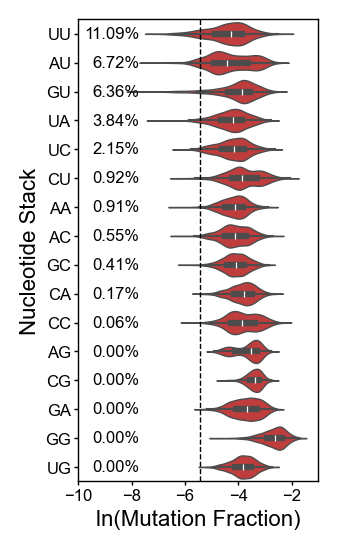

In [ ]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
plot_violins_w_percent_groups(df_ac_2x2, "r_stack", color="tab:red", ax=ax)

# with PDB info with known pairs

## C reactivity trends

In [ ]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
print(len(df_pdb_ca["m_sequence"].unique()))

25


### stacking

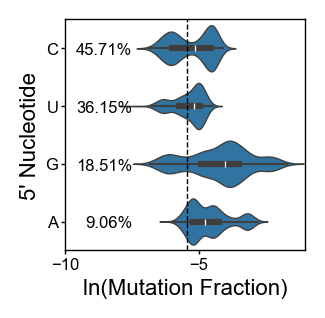

In [ ]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
ax = plot_violinplot_w_percent(
    df_pdb_ca,
    "ln_r_data",
    "p5_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("5' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

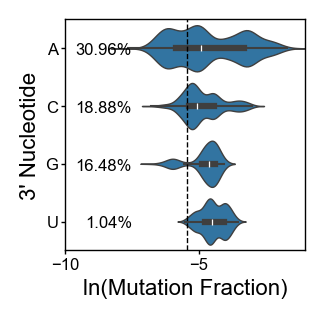

In [ ]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
ax = plot_violinplot_w_percent(
    df_pdb_ca,
    "ln_r_data",
    "p3_res",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("3' Nucleotide", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

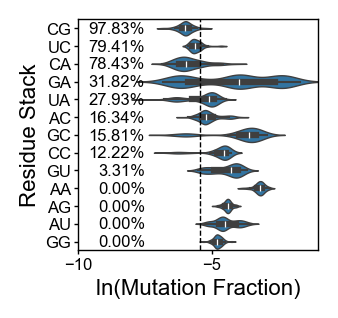

In [ ]:
df_pdb_ca = df_pdb.query(
    "r_nuc == 'C' and r_type == 'NON-WC' and pdb_r_pair == 'C-A' and no_of_interactions == 1"
).copy()
ax = plot_violinplot_w_percent(
    df_pdb_ca,
    "ln_r_data",
    "r_stack",
    color="tab:blue",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
)
ax.set_ylabel("Residue Stack", labelpad=2)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
format_small_plot(ax)

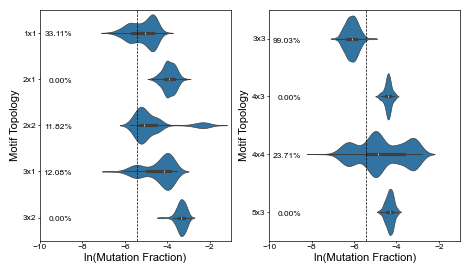

In [ ]:
plot_violins_w_percent_groups(
    df_pdb_ca, "m_token", "ln_r_data", "m_token", "tab:blue", n_panels=2
)

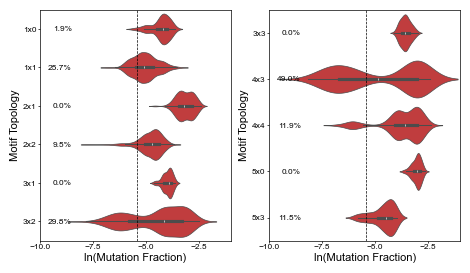

In [ ]:
plot_violins_w_percent_groups(
    df_pdb_ac, "m_token", "ln_r_data", "m_token", "tab:red", n_panels=2
)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

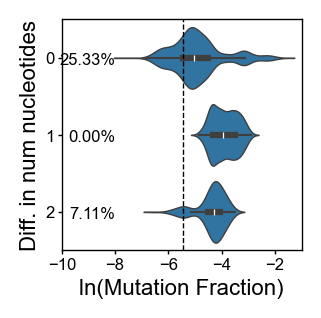

In [ ]:
plot_side_diff_violinplot(df_pdb_ca.query("m_token != '6x3'"), color="tab:blue")

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='ln(Mutation Fraction)', ylabel='Diff. in num nucleotides'>)

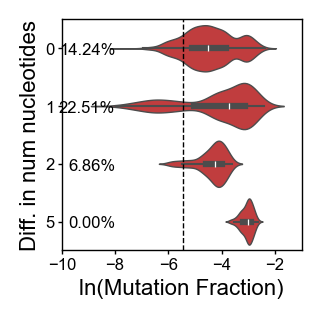

In [ ]:
plot_side_diff_violinplot(df_pdb_ac.query("m_token != '6x3'"), color="tab:red")

### Are A and C reactivity the correlated in a pair

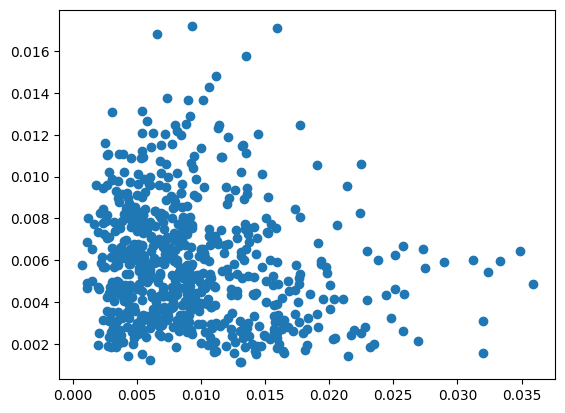

In [ ]:
df_ca_1x1 = df.query(
    "(likely_pair == 'CA' or likely_pair == 'AC') and m_token == '1x1'"
).copy()
data = []
m_seqs = []
for i, g in df_ca_1x1.groupby(["m_sequence", "constructs"]):
    if len(g) != 2:
        continue
    if g.iloc[0]["r_nuc"] == "A":
        data.append([g.iloc[0]["r_data"], g.iloc[1]["r_data"]])
    else:
        data.append([g.iloc[1]["r_data"], g.iloc[0]["r_data"]])
    m_seqs.append(g.iloc[0]["m_sequence"])
data = np.array(data)
plt.scatter(data[:, 0], data[:, 1])

<Axes: xlabel='diff', ylabel='m_sequence'>

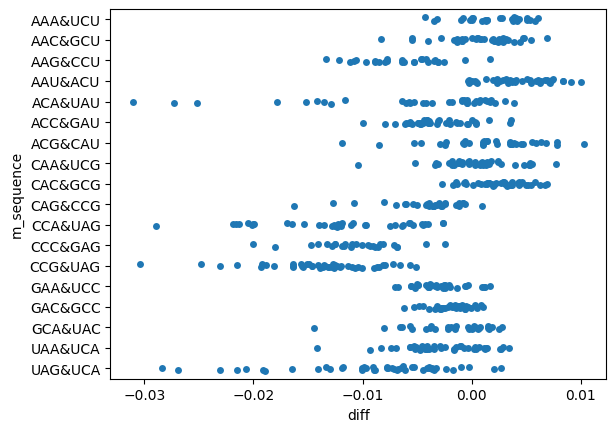

In [ ]:
diffs = []
for i, d in enumerate(data):
    diffs.append([m_seqs[i], d[1] - d[0]])
df_diff = pd.DataFrame(diffs, columns=["m_sequence", "diff"])
sns.stripplot(data=df_diff, y="m_sequence", x="diff")

<Axes: xlabel='r_data', ylabel='m_sequence'>

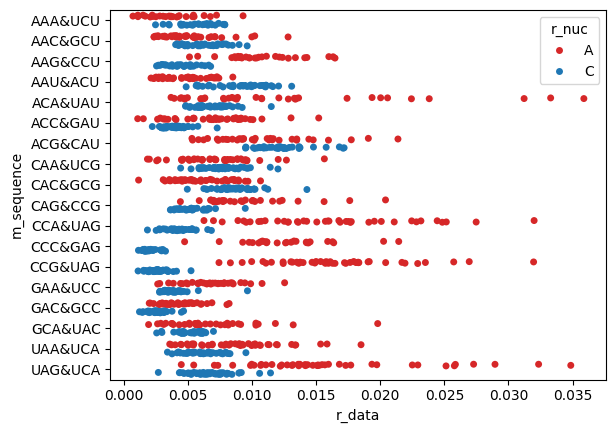

In [ ]:
df_ca_1x1 = df.query(
    "(likely_pair == 'CA' or likely_pair == 'AC') and m_token == '1x1'"
).copy()
sns.stripplot(
    data=df_ca_1x1,
    y="m_sequence",
    x="r_data",
    hue="r_nuc",
    dodge=True,
    jitter=True,
    palette=["tab:red", "tab:blue"],
)

<Axes: xlabel='ln_r_data', ylabel='stack_type'>

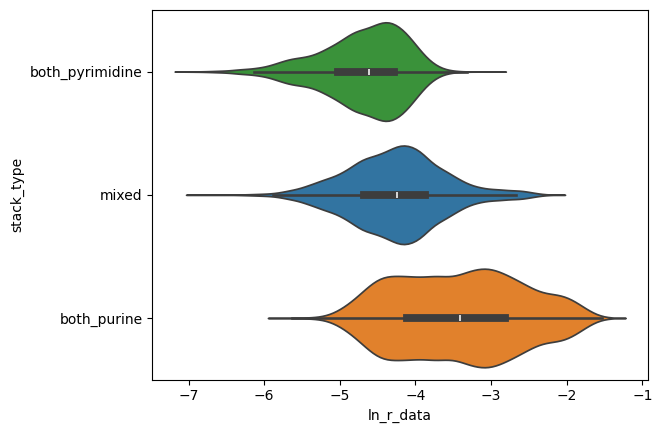

In [ ]:
df_ca_2x2 = df.query("likely_pair == 'CA' and m_token == '2x2'").copy()
df_ca_2x2["stack_type"] = df_ca_2x2.apply(assign_stack_type, axis=1)
sns.violinplot(
    data=df_ca_2x2,
    y="stack_type",
    x="ln_r_data",
    hue="stack_type",
    order=["both_pyrimidine", "mixed", "both_purine"],
)

<Axes: xlabel='ln_r_data', ylabel='stack_type'>

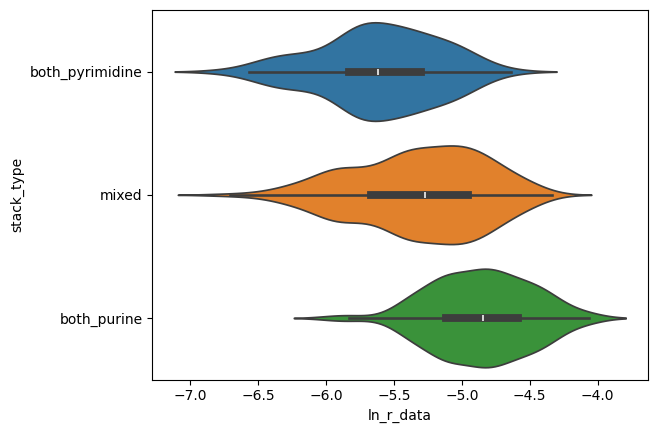

In [ ]:
df_ca = df.query("likely_pair == 'CA' and m_token == '1x1'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
sns.violinplot(
    data=df_ca,
    y="stack_type",
    x="ln_r_data",
    hue="stack_type",
    order=["both_pyrimidine", "mixed", "both_purine"],
)